In [2]:
import torch
from LogSinkhornGPU import *
import matplotlib.pyplot as plt
plt.rc("font", size = 12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We can use the nice structure of the square cost to obtain some efficient parallel solver even when the point clouds of the different problems are displaced with respect each other. Assume we have an efficient routine for computing the formula
	
$$ 
\log \sum_j \exp\left( h_j - \frac{|x_i - x_j|^2}{\varepsilon}\right)
$$
for some point clouds $(x_i)_i$ and $(y_j)_j$. Then, for some translated coordinates $x_i' = x_i + \hat{x}$, $y_j' = y_j + \hat{y}$ one can do: 
	\begin{align*}
    \log \sum_j &\exp\left( h_j - \frac{|x_i' - y_j'|^2}{\varepsilon}\right)
		=
		\log \sum_j \exp\left( h_j - \frac{|x_i - y_j|^2
		+
		2\langle x_i - y_j, \hat{x} - \hat{y} \rangle
		+
		|\hat{x}-\hat{y}|^2
	}{\varepsilon}\right)
\\
&=
\frac{2\langle x_i, \hat{y}- \hat{x} \rangle
	+
	|\hat{x}-\hat{y}|^2}{\varepsilon}
+
\log \sum_j \exp\left( \left[h_j + \frac{2 \langle y_j, \hat{x}-\hat{y} \rangle}{\varepsilon}\right] - \frac{|x_i - y_j|^2}{\varepsilon}\right)
\\
&=
\frac{2\langle x'_i-\hat{x}, \hat{y}- \hat{x} \rangle
	+
	|\hat{x}-\hat{y}|^2}{\varepsilon}
+
\log \sum_j \exp\left( \left[h_j + \frac{2 \langle y_j'-\hat{y}, \hat{x}-\hat{y} \rangle}{\varepsilon}\right] - \frac{|x_i - y_j|^2}{\varepsilon}\right)`
\end{align*}
	
    
So we just need to add an offset to the input and another to the output. Since these offsets can be precomputed, we can perform this operation very efficiently. 

In [51]:
B = 16
n = 32

# Initialize some measures
eps = 0.1
mu = torch.rand(B, n, n, device = "cuda") + 1
nu = torch.rand(B, n, n, device = "cuda") + 1
mu = mu/torch.sum(mu, dim = (1,2), keepdim = True)
nu = nu/torch.sum(nu, dim = (1,2), keepdim = True)
x = torch.linspace(0, 1, n, device = "cuda").view(1, -1)
# Add some random offsets, different for every problem
x1 = x + torch.rand((B, 1), device = "cuda")
x2 = x + torch.rand((B, 1), device = "cuda")
y1 = x + torch.rand((B, 1), device = "cuda")
y2 = x + torch.rand((B, 1), device = "cuda")

xs, ys = (x1, x2), (y1, y2)

# Solve first with torch solver for comparison
C1 = (x1.view(B, -1, 1) - y1.view(B, 1, -1))**2
C2 = (x2.view(B, -1, 1) - y2.view(B, 1, -1))**2
# Torch
solver_torch = LogSinkhornTorchImage(mu, nu, (C1, C2), eps)
solver_torch.iterate_until_max_error()
a_torch = solver_torch.alpha
solver_torch.Niter

80

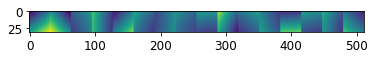

In [52]:
plt.imshow((a_torch).cpu().reshape(B*n, n).T)

In [53]:
# Make solver based on LogSinkhornCudaImage:
class LogSinkhornCudaImageOffset(AbstractSinkhorn):
    """
    Online Sinkhorn solver for standard OT on images with separable cost, custom CUDA implementation. 
    Each Sinkhorn iteration has complexity N^(3/2), instead of the usual N^2. 

    Attributes
    ----------
    mu : torch.Tensor of size (B, M1, M2)
        First marginals
    nu : torch.Tensor of size (B, N1, N2)
        Second marginals 
    C  : tuple of the form ((x1, x2), (y1, y2))
        Grid coordinates
    eps : float
        Regularization strength
    muref : torch.Tensor with same dimensions as mu (except axis 0, which can have len = 1)
        First reference measure for the Gibbs energy, i.e. K = muref \otimes nuref exp(-C/eps)
    nuref : torch.Tensor with same dimensions as nu (except axis 0, which can have len = 1)
        Second reference measure for the Gibbs energy, i.e. K = muref \otimes nuref exp(-C/eps)
    alpha_init : torch.Tensor with same dimensions as mu, or None
        Initialization for the first Sinkhorn potential
    """
    def __init__(self, mu, nu, C, eps, **kwargs):
        
        (xs, ys) = C
        zs = xs + ys # Have all coordinates in one tuple
        x1 = zs[0]
        B = batch_dim(mu)
        # Check whether xs have a batch dimension
        if len(x1.shape) == 1:
            for z in zs:
                assert len(z) == 1, "dimensions of grid coordinates must be consistent"
            C = tuple(tuple(xi.view(1, -1) for xi in X) for X in C)
        else: 
            for z in zs:
                assert len(z.shape) == 2, "coordinates can just have one spatial dimension"
                assert z.shape[0] == B, "batch dimension of all coordinates must coincide"
        
        # Now all coordinates have a batch dimension of either B or 1.
        # Check that all coordinates have same grid spacing
        dx = x1[0,1]-x1[0,0]
        for z in zs:
            assert torch.max(torch.abs(torch.diff(z, dim = -1)-dx)) < 1e-6, "Grid is not equispaced"
            
        # Check geometric dimensions
        Ms = geom_dims(mu)
        Ns = geom_dims(nu)
        assert len(Ms) == len(Ns) == 2, "Shapes incompatible with images"

        # Compute offsets for dual potentials
        dim = len(Ms)
        # For X: compute X such that X[b,i,j,:] is the coordinates (i,j) of slice b
        shapeX = (B, ) + Ms + (dim,)
        X = torch.empty(shapeX, device = mu.device)
        for i in range(dim):
            shapexi = (B,) + (1,)*i + (Ms[i],) + (1,)*(dim-i-1)
            X[...,i] = xs[i].view(shapexi)
        X0 = X[(slice(None),) + (0,)*dim + (slice(None),)].view((B,) + (1,)*dim + (dim,))

        # For Y the same
        shapeY = (B, ) + Ns + (dim,)
        Y = torch.empty(shapeY, device = nu.device)
        for j in range(dim):
            shapeyj = (B,) + (1,)*j + (Ns[j],) + (1,)*(dim-j-1)
            Y[...,j] = ys[j].view(shapeyj)
        Y0 = Y[(slice(None),) + (0,)*dim + (slice(None),)].view((B,) + (1,)*dim + (dim,))
        
        # Use the formulas above to compute the offset
        self.offsetX = torch.sum(2*(X-X0)*(Y0-X0), dim = -1)/eps
        self.offsetY = torch.sum(2*(Y-Y0)*(X0-Y0), dim = -1)/eps
        self.offset_constant = - torch.sum((X0-Y0)**2, dim = -1)/eps

        # Don't need xs or X anymore, just dx
        C = (dx, Ms, Ns)

        super().__init__(mu, nu, C, eps, **kwargs)

    def get_new_alpha(self):
        dx, Ms, Ns = self.C
        h = self.beta / self.eps + self.lognu + self.offsetY
        return - self.eps * (softmin_cuda_image(h, Ms, Ns, self.eps, dx) 
                + self.offsetX + self.offset_constant + self.logmuref - self.logmu)
    
    def get_new_beta(self):
        dx, Ms, Ns = self.C
        h = self.alpha / self.eps + self.logmu + self.offsetX
        return - self.eps * (softmin_cuda_image(h, Ns, Ms, self.eps, dx) 
                + self.offsetY + self.offset_constant + self.lognuref - self.lognu)

In [55]:
solver_offset = LogSinkhornCudaImageOffset(mu, nu, (xs, ys), eps)

solver_offset.iterate_until_max_error()
solver_offset.Niter

80

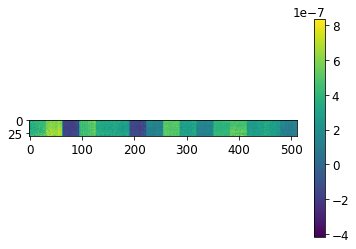

In [56]:
a_offset = solver_offset.alpha.reshape(B, n, n)
plt.imshow((a_offset-a_torch).cpu().reshape(B*n, n).T)
plt.colorbar()